# Numerical Simulation of Stochastic Differential Equations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from tqdm.notebook import trange
import scipy.stats as stats

%matplotlib inline

In [2]:
plt.style.use(['science', 'notebook', 'grid'])

## CONSTANTS


In [3]:
m = 1
l = 1
U_B = 4
R = 0.1
T = 0.5
eta = 1
d = 10
I_0 = 0.0002
T_e = 0.1
e = 5
V = 5 ## IMP ## Overflow at V = 20

## Precalculated
eta_m = eta/m
sqrt_2Teta = np.sqrt(2*T*eta)

## Helper Functions

In [4]:
def defplot_1D(f, plotrange):
    x = np.linspace(plotrange[0],plotrange[1], 200)
    y = [f(i) for i in x]
    plt.plot(x,y)
    return

## Implementation 2 (Euler-Maruyama)

1. $$C_{0}(V) = \dfrac{-4V + 49}{9}$$



2. $$C(x,V) = \dfrac{C_0(V)}{1+\dfrac{x}{d}}$$


3. $$U(x) = U_B\left(\dfrac{x^4}{4l^4} - \dfrac{x^2}{2l^2}\right)$$


4. $$\mathcal{H}(x,p,q) = \dfrac{p^2}{2m} + U(x) + \dfrac{q^2}{2C(x)} - \dfrac{C_{0}(V)V^2}{2d}x + qV$$


5. $$\dfrac{\partial\mathcal{H}}{\partial q} = V + \dfrac{q}{C(x)}$$



6. $$\dfrac{\partial\mathcal{H}}{\partial x} = U'(x) - \dfrac{C_0(V)V^2}{2d} + \dfrac{q^2}{2}\left[\dfrac{C_0(V)d}{(C(x,V))^2(d+x)^2}\right]d$$



7. 
$$ u + 2I_0Rsinh\left(\dfrac{u}{T_e}\right) - V - \dfrac{q}{C} = 0$$


8. $$\mathcal{R} = R + R_E$$

### Functions

In [5]:
def C_0(V):
    '''Base Capacitance'''
    return (-4*V + 49)/9

def C(x,V):
    '''Final Capacitance'''
    return C_0(V)/(1+(x/d))

def U(x):
    '''Potential'''
    return U_B*((x**4/(4*l**4))-(x**2/(2*l**2)))
    

def H(x,p,q,V):
    '''Hamiltonian'''
    return p**2/(2*m) + U(x) + q**2/(2*C(x,V)) - C_0(V)*V**2*x/(2*d)+q*V
    

def dHdq(q,x,V):
    '''dH/dq partial'''
    return V + q/C(x,V)

def dHdx(x,p,q,V):
    '''dH/dx partial'''
    uprime = U_B*(x**3/l**4 - x/l**2)
    C0 = C_0(V)
    Cx  = C(x,V)
    C1 = C0*V**2/(2*d)
    C2 = (q**2/2)*(d*C0/(Cx**2*(d+x)**2))
    return uprime - C1 + C2

def get_u(x,q,V):
    '''Potential Drop across Diodes'''
    sub1 = 2*I_0*R 
    sub2 = V+q/C(x,V)
    def func_u(u):
        return u + sub1*np.sinh(u/T_e)-sub2
    u = fsolve(func_u,1)
    return u

def get_R_E(x,q,V,u = None):
    ''' Equivalent Resistance of Diodes'''
    if u == None:
        u = get_u(x,q,V)
    return u/(2*I_0*np.sinh(u/T_e))
#     return R*u/(V + q/C(x,V) - u)

def dT_Rdq(x,q,V,R_E):
    '''d(T/R)/dq partial'''
    delta = 1e-7
    T1 = -T/(R+R_E)**2
    R_E2 = get_R_E(x, q+delta, V)
    return T1*(R_E2 - R_E)/delta

### Simulation Parameters

* Parameters used in paper : 
    1. *N* = 1 million (using 20)
    2. *n* = 10 million (using 1 million)
    3. Time Horizon = 5000 

In [6]:
N = 1 # Separate Instances
n = 10*10**5 # steps in an instance
T_H = 5000 # Time Horizon for an instance
times = np.linspace(0,T_H,n)
dt = times[1] - times[0]

### Simulation

#### **1. Constant Bias Potential** (V = 5V)

In [7]:
x_values = np.zeros((n,N))
p_values = np.zeros((n,N))
q_values = np.zeros((n,N))
I_values = np.zeros((n,N))
R_net_values = np.zeros((n,N))
u_values = np.zeros((n,N))

dwp = np.sqrt(dt)*np.random.normal(size = (n,N))
dwq = np.sqrt(dt)*np.random.normal(size = (n,N))

dwp2 = sqrt_2Teta*dwp #Precalculated

# dWdt = np.zeros((n,N))

for i in trange(N, desc='Instances Completed'):

    for j in trange(n-1, desc=f'Completion of Instance {i+1}'):

        # update x
        x_values[j+1,i] = x_values[j,i] + p_values[j,i]/m*dt

        # update p
        p_values[j+1,i] = p_values[j,i] - (eta_m*p_values[j,i] + dHdx(x_values[j,i], p_values[j,i], q_values[j,i],V))*dt + dwp2[j,i]


        # get u : Potential Drop across diodes
        u = get_u(x_values[j,i],q_values[j,i],V)
        u_values[j,i] = u
        
        # getting net resistance
        R_E = get_R_E(x_values[j,i], q_values[j,i], V, u) 
        R_net = R + R_E
        R_net_values[j,i] = R_net

        # storing total current
        I_values[j+1,i] = -(1/R_net)*(V + q_values[j,i]/C(x_values[j,i],V))

        # update q
        q_values[j+1,i] = q_values[j,i] + (dT_Rdq(x_values[j,i], q_values[j,i],V, R_E)-1/R_net*(V + q_values[j,i]/C(x_values[j,i],V)))*dt + np.sqrt(2*T/R_net)*dwq[j,i]
        
        #update dWdt
        
# np.save("10instances.npy", np.stack([x_values, p_values, q_values, I_values, R_net_values, u_values], axis = 2))

Instances Completed:   0%|          | 0/1 [00:00<?, ?it/s]

Completion of Instance 1:   0%|          | 0/999999 [00:00<?, ?it/s]

## Plots

In [12]:
# Loader

z = np.load("20instances.npy")
z2 = np.load("20instances_newer.npy")
z3 = z2[:,:,:6]
final = np.concatenate([z,z3], axis = 1)
x_values = final[:,:,0]
p_values = final[:,:,1]
q_values = final[:,:,2]
I_values = final[:,:,3]
R_net_values = final[:,:,4]
u_values = final[:,:,5]

In [13]:
x_values.shape

(1000000, 40)

In [14]:
N = 40

In [15]:
# Choose which instance to plot
import random
instance = None
if instance is None:
    instance = random.choice(list(range(N))) 
print(f"Plotting for instance {instance + 1} of {N}")

Plotting for instance 20 of 40


## $x$ v/s $t$

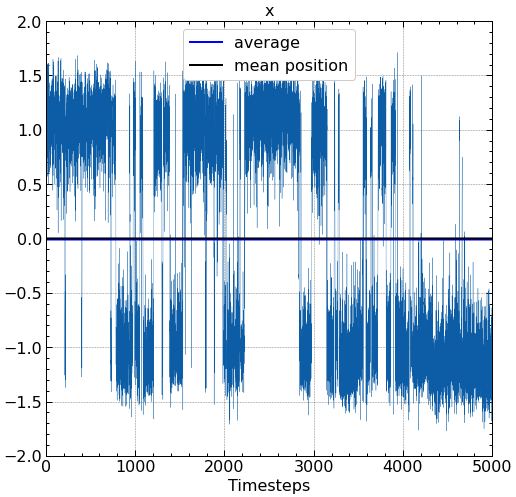

In [43]:
instance = 13
plt.figure(figsize = (8,8))
plt.xlabel("Timesteps")
plt.xlim(0,T_H)

plt.plot(times, x_values[:, instance], linewidth = 0.3)
plt.plot(times, np.ones((n,1))*np.mean(x_values[:,instance]), color = "blue", label = "average")
plt.plot(times, np.zeros((n,1)), color = "black", label = "mean position")
plt.title("x")
plt.ylim(-2,2)
plt.legend(loc = "upper center")

# plt.plot(times, p_values[:, instance], linewidth = 0.25)
# plt.plot(times, R_net_values[:, instance], linewidth = 0.25)
# plt.plot(times, u_values[:, instance], linewidth = 0.25)
# plt.title("$\mathcal{R}$")


## $q$ v/s $t$

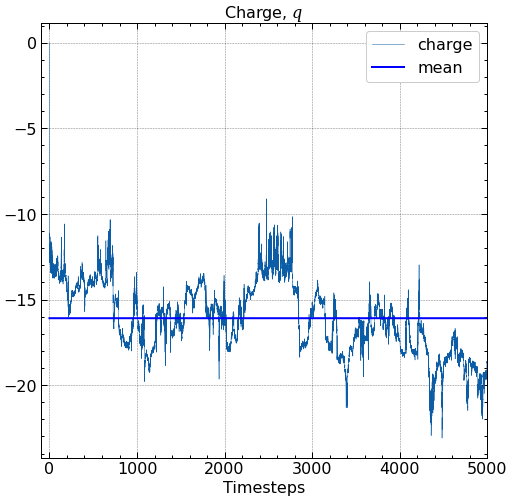

In [32]:
instance = 13

plt.figure(figsize = (8,8))
plt.xlabel("Timesteps")
plt.xlim(-100,T_H)

# plt.plot(times, q_values[:, instance]/3, linewidth = 0.25)
plt.plot(times, q_values[:, instance], linewidth = 0.5,label = "charge")
plt.plot(times, np.ones((n,1))*np.mean(q_values[:,instance]), color = 'blue',  label = "mean")
# plt.ylim(-25,0)
# plt.xlim(-100,T_H)
plt.title("Charge, $q$")
plt.legend()

## $I$ v/s $t$

(-10.0, 10.0)

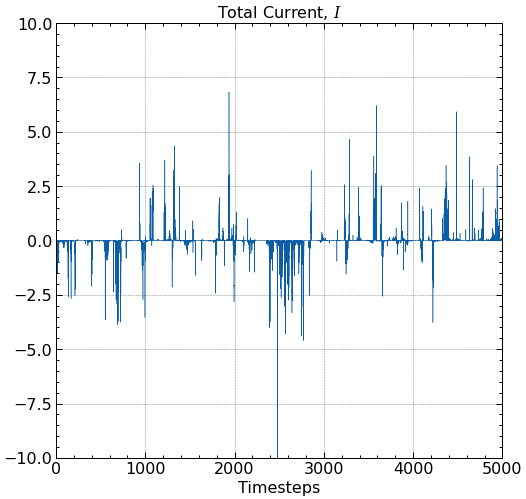

In [33]:
instance = 13

plt.figure(figsize = (8,8))
plt.xlabel("Timesteps")
plt.xlim(0,T_H)

plt.plot(times, I_values[:, instance], linewidth = 0.5)
plt.title("Total Current, $I$")
plt.ylim(-10,10)

## Brownian Noise

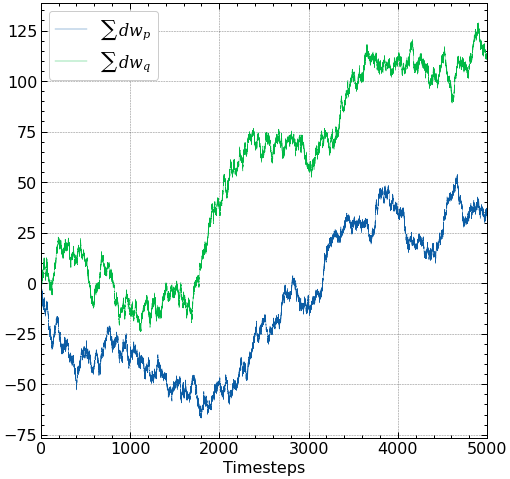

In [34]:
instance1 = 0
plt.figure(figsize = (8,8))
plt.xlabel("Timesteps")
plt.xlim(0,T_H)

plt.plot(times, np.cumsum(dwp[:,instance1]) , label = "$\sum\, dw_p$", linewidth = 0.4)
plt.plot(times, np.cumsum(dwq[:,instance1]), label = "$\sum \,dw_q$", linewidth = 0.4)
plt.legend()

## Average Calculation

### 1. $$\left\langle \dfrac{d'Q}{dt}\right\rangle = \dfrac{\eta}{m}\left(T - \left\langle \dfrac{p^2}{m}\right\rangle \right)$$

In [35]:
dQdt = np.array([eta_m*(T - np.average(p_values[:,i]**2/m)) for i in range(N)])
mean = np.mean(dQdt)
std = np.std(dQdt)
print("Mean = ", mean)
print("Std  = ", std)

Mean =  -0.02309176366514734
Std  =  0.011019708953354636


Text(0.5, 1.0, "Normal Distribution ; <$d'Q/dt$>")

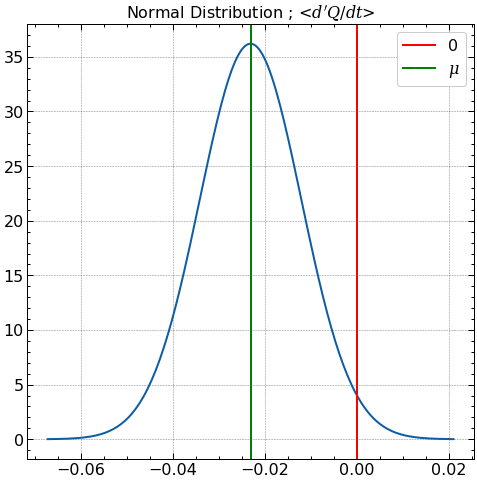

In [36]:
plt.figure(figsize = (8,8))
x = np.linspace(mean + 4*std, mean - 4*std, 200)
plt.plot(x, stats.norm.pdf(x, mean, std))
plt.axvline(0, color='red', label = "0")
plt.axvline(mean, color = 'green', label = "$\mu$")
plt.legend()
plt.title("Normal Distribution ; <$d'Q/dt$>")

### 2. $$\left\langle \dfrac{d'W}{dt} \right\rangle = \left\langle \dfrac{\partial}{\partial q} \left(\dfrac{T}{\mathcal{R}}\dfrac{\partial \mathcal{H}}{\partial q}\right)\right\rangle - \left\langle \dfrac{1}{\mathcal{R}}\left(\dfrac{\partial \mathcal{H}}{\partial q}\right)^2 \right\rangle$$

In [37]:
dWdt = []

for i in trange(N, desc='Instances Completed'):
    T1 = []
    T2 = []
    precalc = 2*e*I_0
    for j in trange(n-1, desc=f'Completion of Instance {i+1}'):
        Cx = C(x_values[j,i],V)
        t3 = V + q_values[j,i]/Cx
        R_net = R_net_values[j,i]
        if Cx == 0 or t3==0 or R_net==0:
            continue
        t1 = precalc*np.cosh(u_values[j,i]/T_e)/(Cx*(1 + 2*I_0*R*np.cosh(u_values[j,i]/T_e)/T_e))
        t2 = 1/R_net*(t3**2)
        T1.append(t1)
        T2.append(t2)
#         if t1 == np.inf or t1 == 0:
#             print(j)
    dWdt.append(np.mean(T1) - np.mean(T2))

mean2 = np.mean(dWdt)
std2 = np.std(dWdt)
print("Mean = ", mean2)
print("Std  = ", std2)

Instances Completed:   0%|          | 0/40 [00:00<?, ?it/s]

Completion of Instance 1:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 2:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 3:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 4:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 5:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 6:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 7:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 8:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 9:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 10:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 11:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 12:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 13:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 14:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 15:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 16:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 17:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 18:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 19:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 20:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 21:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 22:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 23:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 24:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 25:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 26:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 27:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 28:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 29:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 30:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 31:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 32:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 33:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 34:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 35:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 36:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 37:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 38:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 39:   0%|          | 0/999999 [00:00<?, ?it/s]

Completion of Instance 40:   0%|          | 0/999999 [00:00<?, ?it/s]

Mean =  -0.008184436196814558
Std  =  0.003992071322733361


Text(0.5, 1.0, "Normal Distribution ; <$d'W/dt$>")

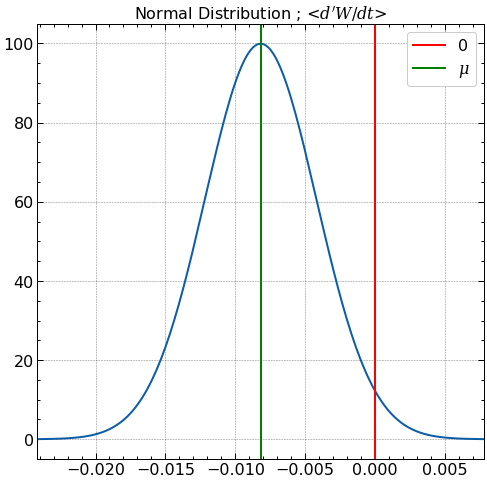

In [23]:
plt.figure(figsize = (8,8))
x = np.linspace(mean2 + 4*std2, mean2 - 4*std2, 200)
plt.plot(x, stats.norm.pdf(x, mean2, std2))
plt.xlim(mean2 - 4*std2, mean2 + 4*std2)
plt.axvline(0, color='red', label = "0")
plt.axvline(mean2, color = 'green', label = "$\mu$")
plt.legend()
plt.title("Normal Distribution ; <$d'W/dt$>")

# plt.xlabel("Timesteps")
# plt.ylabel("Power")

## Power Dissipated 

Text(0, 0.5, 'Power')

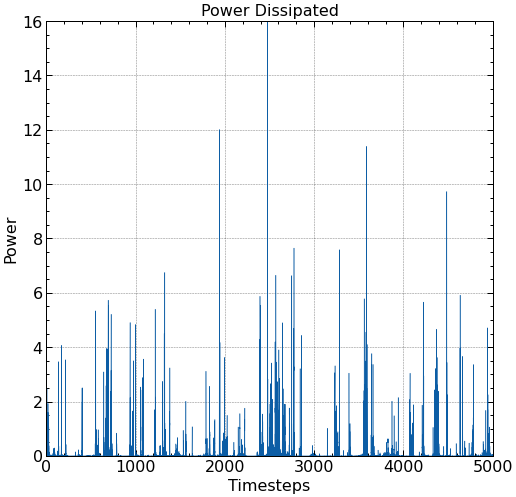

In [39]:
plt.figure(figsize = (8,8))
# instance = 0
Instantaneous_Power = I_values[:,instance]**2*R_net_values[:,instance]
plt.title("Power Dissipated")
# Instantaneous_Power2 = u_values[:,instance]**2/(R_net_values[:,instance] - R)
# plt.title("Dissipated in D2")

plt.plot(times, Instantaneous_Power, linewidth = 0.5)
# plt.plot(times, Instantaneous_Power2, linewidth = 0.2)

plt.ylim(0,16)
plt.xlim(0,5000)
plt.xlabel("Timesteps")
plt.ylabel("Power")

In [34]:
# np.save("20instances_newer.npy", np.stack([x_values, p_values, q_values, I_values, R_net_values, u_values, dwp, dwq], axis = 2))